In [45]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import OrderedDict
from multiprocessing import Pool
from numba import jit
from tqdm.auto import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa import arima_process
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)


sns.set_context("paper", font_scale=1.7)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
    },
)

# Import Data

In [46]:
%%time
data_files = glob.glob("../data/returns/ticker_daily_rv/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    # Magic number for the number of observations each file should have
    if len(ticker_df) == 1447:
        ticker_dfs.append(ticker_df)

data_rv_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 2.73 s, sys: 3.86 s, total: 6.59 s
Wall time: 4.25 s


# Clean Data

## Additional Vars

In [47]:
data_rv_df['1'] = 1
data_rv_df['rvol'] = np.sqrt(data_rv_df['rv'])

In [48]:
# Drop nee
data_rv_df = data_rv_df.query('ticker != "NEE"').copy()

## Lagged Measures

In [49]:
data_rv_df = data_rv_df.sort_values(by = ['ticker', 'date'])

# Signed Jump variants
data_rv_df['sgn_jump_var_pos'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] > 0)
data_rv_df['sgn_jump_var_neg'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] < 0)

data_rv_df['rq'] = data_rv_df['return_p4']/3
data_rv_df['sqrt_rq'] = np.sqrt(data_rv_df['rq'])

data_rv_df['year'] = data_rv_df['date'].dt.year

In [50]:
# Lags
data_rv_df["rv_d_lag_1"] = data_rv_df["return_d_p2"].shift(1)
data_rv_df["rv_d_lag_m5"] = data_rv_df["rv_lag_1"].rolling(5).mean()
data_rv_df["rv_d_lag_m22"] = data_rv_df["rv_lag_1"].rolling(22).mean()

In [51]:
lag_coeff_cols = [
    "return_j_pos",
    "return_j_neg",
    "return_d_pos",
    "return_d_neg",
    "sum_jump_p2_1",
    "sum_jump_p2_5",
    "sum_jump_p2_22",
    "sum_jump_p2_pos_1",
    "sum_jump_p2_pos_5",
    "sum_jump_p2_pos_22",
    "sum_jump_p2_neg_1",
    "sum_jump_p2_neg_5",
    "sum_jump_p2_neg_22",
    "sgn_jump_var",
    "sgn_jump_var_pos",
    "sgn_jump_var_neg",
    "sqrt_rq",
]

interact_cols = [
    "rv_lag_1",
    "rv_lag_m5",
    "rv_lag_m22",
    "rv_d_lag_1",
    "rv_d_lag_m5",
    "rv_d_lag_m22",
]

for col in tqdm(lag_coeff_cols):
    data_rv_df[col + "_lag_1"] = data_rv_df.groupby("ticker")[col].shift(1)

    for icol in interact_cols:
        data_rv_df[f"{icol}:{col}_lag_1"] = np.multiply(
            data_rv_df[icol], data_rv_df[col + "_lag_1"]
        )

# Rolling Beta

In [52]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [53]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

In [54]:
%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_beta_df = pd.concat(results)


CPU times: user 734 ms, sys: 2.64 s, total: 3.38 s
Wall time: 1min 11s


In [55]:
coeff_cols = ["rv_lag_1", "rv_lag_m5", "rv_lag_m22"]
data_rv_df = data_rv_df.merge(
    rolling_beta_df.rename(columns={x: (x + "_rollcoeff") for x in coeff_cols}).drop(
        "Intercept", axis=1
    ),
    on=["date", "ticker"], how = 'left'
)

<AxesSubplot:xlabel='date'>

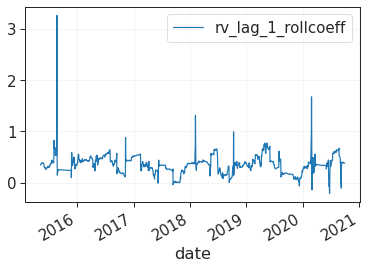

In [56]:
data_rv_df.query('ticker == "AAPL"').plot(x = 'date', y = 'rv_lag_1_rollcoeff')

# Forecast Analysis

## Forecast Funcs

In [57]:
from numba.core.errors import NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

## Numba functions, about 90 times faster than usual ones
@jit(nopython = True)
def numba_ols(y, x):
    beta_hat = np.linalg.pinv(x.T @ x) @ (x.T @ y)
    return beta_hat

# Compile by running on some random data
numba_ols(np.random.normal(0,1,(100,1)), np.random.normal(0,1,(100,3)));

In [58]:
# def get_forecast_error_ols(ticker_rv_df, endog_vars, exog_vars, window, skip_rows):

#     # Set up regression dataframe
#     exog_vars = [x.strip() for x in exog_vars.replace('\n', '').split('+')]
#     reg_data_df = ticker_rv_df[[endog_vars] + exog_vars].iloc[(skip_rows-1):,:].reset_index(drop = True)

#     if np.any(reg_data_df.isna()):
#         print(np.any(reg_data_df.isna(), axis = 0))
#         raise Exception('NA Values in reg data')

#     end_index = len(reg_data_df)
#     reg_data_array = reg_data_df.values
#     forecast_loss_array = []

#     is_switch_estimator = 'switch' in ''.join(exog_vars)
#     is_jump_estimator = 'jump' in ''.join(exog_vars)
    
#     for i in range(0, end_index-window+1):

#         reg_data_array_splice = np.asfortranarray(reg_data_array[i:(i+window),:])

#         # Regress on winow-1 observations
#         train_endog, train_exog = reg_data_array_splice[:(window-1),0], reg_data_array_splice[:(window-1),1:]

#         # Testing observations
#         test_endog, test_exog = reg_data_array_splice[-1,0], reg_data_array_splice[-1,1:]

#         # Regress and get forecast error
#         forecast = test_exog @ numba_ols(train_endog, train_exog) 
#         if is_switch_estimator or is_jump_estimator:
#             forecast = np.max([np.min(train_endog), forecast])
#             forecast = np.min([np.max(train_endog), forecast])
# #         forecast_loss = np.square(test_endog - forecast)
#         forecast_loss = np.log(np.max([forecast, 4e-7])) + test_endog/np.max([forecast, 4e-7])
#         forecast_loss_array.append(forecast_loss)
        
#     return forecast_loss_array

In [242]:
@jit(nopython = True)
def est_forecast_loss(reg_data_array, window, end_index, use_insanity_filter, is_switch):
    
    forecast_loss_array = []
    
    for i in range(0, end_index-window+1):
        
        reg_data_array_splice = np.asfortranarray(reg_data_array[i:(i+window),:])

        # Regress on winow-1 observations
        train_endog, train_exog = reg_data_array_splice[:(window-1),0], reg_data_array_splice[:(window-1),1:]

        # Testing observations
        test_endog, test_exog = reg_data_array_splice[-1,0], reg_data_array_splice[-1,1:]

        # Regress and get forecast error
        forecast = test_exog @ numba_ols(train_endog, train_exog) 
        if is_switch:
            forecast = np.max(np.array([np.min(train_endog), forecast]))
            forecast = np.min(np.array([np.max(train_endog), forecast]))
        else:
            if use_insanity_filter:
                if (forecast > np.max(train_endog)) or (forecast < np.min(train_endog)):
                    forecast = np.mean(train_endog)

        # MSE
#         forecast_loss = np.square(test_endog - forecast)
        
        # QLIKE
        train_endog_min = np.min(train_endog)
        forecast = np.max(np.array([1e-5, forecast]))
        forecast_loss = np.log(forecast) + test_endog/forecast - np.log(test_endog) -1
        
        forecast_loss_array.append(forecast_loss)
        
    return forecast_loss_array

def get_forecast_error_ols(ticker_rv_df, endog_vars, exog_vars, window, skip_rows):

    # Set up regression dataframe
    exog_vars = [x.strip() for x in exog_vars.replace('\n', '').split('+')]
    reg_data_df = ticker_rv_df[[endog_vars] + exog_vars].iloc[(skip_rows):,:].reset_index(drop = True)

    if np.any(reg_data_df.isna()):
        print(np.any(reg_data_df.isna(), axis = 0))
        raise Exception('NA Values in reg data')

    end_index = len(reg_data_df)
    reg_data_array = reg_data_df.values

#     use_insanity_filter = True
    is_switch = 'switch' in ''.join(exog_vars)
    use_insanity_filter = (('switch' in ''.join(exog_vars)) 
                           or ('jump' in ''.join(exog_vars))  
                           or ('rq' in ''.join(exog_vars))
                          )
    
    output = est_forecast_loss(reg_data_array, window, end_index, use_insanity_filter, is_switch)
        
    return output

# Run once to compile
_ = get_forecast_error_ols(data_rv_df.query('ticker == "AMZN"'), 
                           'rv', '1 + rv_lag_1', 250, 50)

## Set up switch

In [243]:
data_rv_df["persistence"] = (
    data_rv_df["rv_lag_1_rollcoeff"]
    + data_rv_df["rv_lag_m5_rollcoeff"]
    + data_rv_df["rv_lag_m22_rollcoeff"]
)


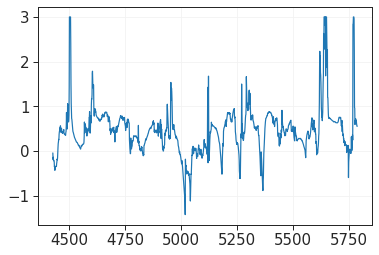

In [244]:
plt.plot(data_rv_df.query('ticker == "AAPL"')['persistence'].clip(-3, 3))

In [245]:
data_rv_df["indicator_high_beta"] = data_rv_df["persistence"].clip(-3, 3) > 0.6
data_rv_df["switch"] = (
    data_rv_df.groupby("ticker")["indicator_high_beta"]
    .rolling(22)
    .mean()
    .reset_index(drop=True)
)
data_rv_df["switch_lag_1"] = (
    data_rv_df.groupby("ticker")["switch"].shift(1).reset_index(drop=True)
)

<AxesSubplot:xlabel='date', ylabel='switch'>

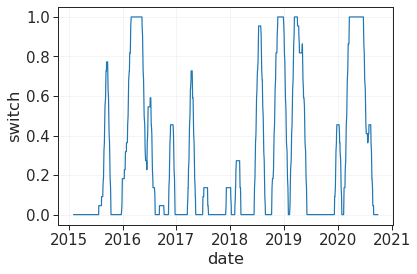

In [246]:
sns.lineplot(x = 'date', y = 'switch', data = data_rv_df.query('ticker == "AMZN"'))

In [247]:
data_rv_df['switchn'] = 1 - data_rv_df['switch']
data_rv_df['switchn_lag_1'] = 1 - data_rv_df['switch_lag_1']
data_rv_df['bv_lag_1'] = data_rv_df.groupby('ticker')['bipower_var_daily'].shift(1)
data_rv_df['sgn_jump_var_pos_lag_1']  = data_rv_df['sgn_jump_var_lag_1']*(data_rv_df['sgn_jump_var_pos_lag_1'] > 0)
data_rv_df['sgn_jump_var_neg_lag_1']  = data_rv_df['sgn_jump_var_lag_1']*(data_rv_df['sgn_jump_var_neg_lag_1'] < 0)

interact_cols = [
    'rv_lag_1',
    'rv_lag_m5',
    'rv_lag_m22',
    'rv_d_lag_1',
    'rv_d_lag_m5',
    'rv_d_lag_m22',
    'bv_lag_1',
    'rv_lag_1:sqrt_rq_lag_1',
    'rv_lag_m5:sqrt_rq_lag_1',
    'rv_lag_m22:sqrt_rq_lag_1',
]

for col in tqdm(interact_cols):
    data_rv_df[f'{col}:switchn_lag_1'] = data_rv_df[col]*data_rv_df['switchn_lag_1']

## Performance

### Regressions

In [248]:
# Params
window = 250
skip_rows = 44
endog_vars = 'rv'

In [249]:
exog_vars_list = [
'''
1 + rv_lag_1
+ rv_lag_m5
+ rv_lag_m22
''',
# '''
# 1 + rv_lag_1
# + rv_lag_1:sqrt_rq_lag_1
# + rv_lag_m5
# + rv_lag_m22
# ''',
# '''
# 1 + sgn_jump_var_pos_lag_1 + sgn_jump_var_pos_lag_1 + bv_lag_1 +
# rv_lag_m5 + rv_lag_m22
# ''',
'''
1 + switchn_lag_1 
+ rv_lag_1 + rv_lag_1:switchn_lag_1 + 
rv_lag_m5:switchn_lag_1 + rv_lag_m22:switchn_lag_1
''',
# '''
# 1 + switchn_lag_1 
# + rv_lag_1 + rv_lag_1:switchn_lag_1 + 
# rv_lag_m5 + rv_lag_m5:switchn_lag_1 + 
# rv_lag_m22 + rv_lag_m22:switchn_lag_1
# ''',
# '''
# 1 + switchn_lag_1 + sgn_jump_var_lag_1 
# + bv_lag_1 + bv_lag_1:switchn_lag_1 + 
# rv_lag_m5:switchn_lag_1
# '''
]

In [250]:
data_tickers_rv_df = data_rv_df.set_index('ticker').copy()
ticker_list = list(data_tickers_rv_df.index.unique())

In [251]:
def temp_f(ticker):

    ticker_rv_df = data_tickers_rv_df.loc[ticker, :]
        
    forecast_loss_list = []
    for exog_vars in exog_vars_list:
        
        try:
            forecast_loss = (
                get_forecast_error_ols(ticker_rv_df, endog_vars, exog_vars, window, skip_rows)
            )
        except:
            raise Exception(f'Issue with {ticker} and\n{exog_vars}')
        forecast_loss_list.append(forecast_loss)
        
    return [ticker] + [forecast_loss_list]

In [252]:
%%time
ols_reg_results = []

with Pool(8) as p:

    for result in tqdm(
        p.imap_unordered(temp_f, ticker_list, chunksize = 25), total=len(ticker_list)
    ):
        ols_reg_results.append(result)


CPU times: user 93.8 ms, sys: 4.53 s, total: 4.62 s
Wall time: 10 s


### Format Reg Results

In [253]:
# Formatted results
reg_names = [
    'har', 
#     'harq', 
#     'har_sgn_bv',
    'har_ls',
#     'har_ls_extend',
]

results_df = pd.DataFrame(ols_reg_results, 
                          columns = ['ticker', 'forecast_error_results']).set_index('ticker')

results_df["forecast_error_means"] = (
    results_df["forecast_error_results"]
    .apply(lambda x: np.mean(np.array(x), axis=1))
    .values
)
results_df["forecast_error_medians"] = (
    results_df["forecast_error_results"]
    .apply(lambda x: np.median(np.array(x), axis=1))
    .values
)

results_df[[x + '_mean' for x in reg_names]] = results_df['forecast_error_means'].apply(pd.Series)
results_df[[x + '_median' for x in reg_names]] = results_df['forecast_error_medians'].apply(pd.Series)

results_df = results_df.reset_index()
results_df

,ticker,forecast_error_results,forecast_error_means,forecast_error_medians,har_mean,har_ls_mean,har_median,har_ls_median
0,CCI,"[[0.0012058383520514582, 0.14751357164655055, ...","[0.5455378891899508, 0.20487562891269745]","[0.06164501933046118, 0.07253861447410781]",0.545538,0.204876,0.061645,0.072539
1,CCL,"[[0.0068102958346925035, 0.01674159409853715, ...","[0.8354205753018833, 0.39114672353313823]","[0.07871141853705743, 0.09188780500474447]",0.835421,0.391147,0.078711,0.091888
2,CDNS,"[[0.19468526910920403, 0.03297391390951354, 0....","[0.34673449466921885, 0.18842287133374866]","[0.06211851530422896, 0.07389695173905331]",0.346734,0.188423,0.062119,0.073897
3,CDW,"[[0.035619610401105284, 0.201385470031334, 0.0...","[0.4941260487351148, 0.18678064713354886]","[0.05930446724131988, 0.06628940835139563]",0.494126,0.186781,0.059304,0.066289
4,CE,"[[0.2176985504030764, 0.006937663530911742, 0....","[0.45572240092617433, 0.17372318301625114]","[0.059193379193341666, 0.06675084400949638]",0.455722,0.173723,0.059193,0.066751
...,...,...,...,...,...,...,...,...
449,XLNX,"[[0.18433062218604945, 0.006431588222262086, 0...","[0.20976532038210982, 0.23682550897058036]","[0.07862617410528516, 0.08469235823626642]",0.209765,0.236826,0.078626,0.084692
450,XOM,"[[0.007438772507120994, 0.011337026542888928, ...","[1.0474066484028255, 0.4517474230444368]","[0.05861492875039609, 0.07198772131993003]",1.047407,0.451747,0.058615,0.071988
451,XRAY,"[[0.1901893302634008, 0.0009559873904185778, 0...","[0.23126384079700793, 0.1892166586716687]","[0.06276065699911548, 0.0622224105527609]",0.231264,0.189217,0.062761,0.062222
452,XRX,"[[0.0017839696397272675, 0.015209416724729863,...","[1.6197044594838619, 0.3386237765859707]","[0.07052294723704478, 0.08035864377818314]",1.619704,0.338624,0.070523,0.080359


### Descriptive Stats

In [254]:
results_mean_mean = pd.DataFrame(
    results_df[[x for x in results_df.columns if "mean" in x]].mean() * 1e6
)
results_mean_mean/1e6

,0
forecast_error_means,0.494764
har_mean,0.494764
har_ls_mean,0.253990


In [255]:
reg_formulas_fmt = [x.replace('\n', ' ').strip() for x in exog_vars_list]

In [256]:
results_mean_mean = pd.DataFrame(
    results_df[[x for x in results_df.columns if "mean" in x and 'forecast' not in x]].mean() * 1e6
)
results_mean_median = pd.DataFrame(
    results_df[[x for x in results_df.columns if "mean" in x and 'forecast' not in x]].median() * 1e6
)

print(((results_mean_mean/results_mean_mean.loc['har_mean',0]).T).round(4).to_latex())
print(((results_mean_median/results_mean_median.loc['har_mean',0]).T).round(4).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  har\_mean &  har\_ls\_mean \\
\midrule
0 &       1.0 &       0.5134 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  har\_mean &  har\_ls\_mean \\
\midrule
0 &       1.0 &       0.5476 \\
\bottomrule
\end{tabular}



In [259]:
## Ticker subset
ticker_subset = np.sort(["MSFT", 'AAPL', 'GOOG', 'AMZN', 'FB', 
                         'JPM', 'JNJ','V'])
results_mean_tickers = results_df.query("ticker in @ticker_subset")[
    ["ticker"] + [col for col in results_df.columns if "mean" in col and 'means' not in col and 'simple' not in col]
].reset_index()

for col in results_mean_tickers:
    if "mean" in col and col != 'har_mean':
        results_mean_tickers[col] = (
            results_mean_tickers[col] / results_mean_tickers["har_mean"]
        )

results_mean_tickers['har_mean'] = 1
print(results_mean_tickers.round(4).iloc[:,1:].set_index('ticker').to_latex().replace(' 1 &', ' 1.000 &'))

\begin{tabular}{lrr}
\toprule
{} &  har\_mean &  har\_ls\_mean \\
ticker &           &              \\
\midrule
AMZN   &         1.000 &       1.0437 \\
GOOG   &         1.000 &       0.6707 \\
AAPL   &         1.000 &       1.1852 \\
FB     &         1.000 &       0.7979 \\
JNJ    &         1.000 &       1.4828 \\
JPM    &         1.000 &       0.4975 \\
MSFT   &         1.000 &       1.8231 \\
V      &         1.000 &       0.4507 \\
\bottomrule
\end{tabular}



In [260]:
pd.DataFrame(
    results_df[[x for x in results_df.columns if "mean" in x]].median() * 1e6
).style.background_gradient(cmap=matplotlib.cm.viridis_r)

,0
har_mean,396520.722596
har_ls_mean,217123.945896


### Forecast Error $L_{m,i,t}$

In [261]:
len(data_rv_df.query('ticker == "AAPL"')) 

1447

In [262]:
results_df[[x + '_fer' for x in reg_names]] = results_df['forecast_error_results'].apply(pd.Series).applymap(np.array)

for reg_name in reg_names:
    if reg_name != 'har':
        results_df['har_vs_' + reg_name + '_Y'] = results_df['har_fer'] - results_df[reg_name + '_fer']
        
results_df.head()

,ticker,forecast_error_results,forecast_error_means,forecast_error_medians,har_mean,har_ls_mean,har_median,har_ls_median,har_fer,har_ls_fer,har_vs_har_ls_Y
0,CCI,"[[0.0012058383520514582, 0.14751357164655055, ...","[0.5455378891899508, 0.20487562891269745]","[0.06164501933046118, 0.07253861447410781]",0.545538,0.204876,0.061645,0.072539,"[0.0012058383520514582, 0.14751357164655055, 0...","[0.04522723698349829, 0.04943139159174059, 0.0...","[-0.04402139863144683, 0.09808218005480995, 0...."
1,CCL,"[[0.0068102958346925035, 0.01674159409853715, ...","[0.8354205753018833, 0.39114672353313823]","[0.07871141853705743, 0.09188780500474447]",0.835421,0.391147,0.078711,0.091888,"[0.0068102958346925035, 0.01674159409853715, 0...","[0.03895305950098127, 0.07415504964886477, 0.2...","[-0.032142763666288765, -0.05741345555032762, ..."
2,CDNS,"[[0.19468526910920403, 0.03297391390951354, 0....","[0.34673449466921885, 0.18842287133374866]","[0.06211851530422896, 0.07389695173905331]",0.346734,0.188423,0.062119,0.073897,"[0.19468526910920403, 0.03297391390951354, 0.1...","[0.08781651399769608, 7.69915432208279e-06, 0....","[0.10686875511150795, 0.03296621475519146, 0.1..."
3,CDW,"[[0.035619610401105284, 0.201385470031334, 0.0...","[0.4941260487351148, 0.18678064713354886]","[0.05930446724131988, 0.06628940835139563]",0.494126,0.186781,0.059304,0.066289,"[0.035619610401105284, 0.201385470031334, 0.05...","[8.273377938383675e-05, 0.0017029954890759313,...","[0.03553687662172145, 0.19968247454225807, -0...."
4,CE,"[[0.2176985504030764, 0.006937663530911742, 0....","[0.45572240092617433, 0.17372318301625114]","[0.059193379193341666, 0.06675084400949638]",0.455722,0.173723,0.059193,0.066751,"[0.2176985504030764, 0.006937663530911742, 0.0...","[0.22265665961931003, 0.0020746232912252083, 0...","[-0.0049581092162336304, 0.0048630402396865335..."


### HAR Performance - Trimming at Quantiles

In [278]:
def get_rel_mean_error(results_df, drop_covid=False):
    
    if drop_covid:
        
        temp_results = []

        for reg_name in reg_names:
            result = np.mean(np.vstack(np.array(results_df[reg_name + '_fer']))[:,:-189])
            temp_results.append(result)      
            
        results_mean_mean = pd.DataFrame(temp_results, index = [x + '_mean' for x in reg_names])
            
            
    else:
        results_mean_mean = pd.DataFrame(
            results_df[
                [x for x in results_df.columns if "mean" in x if "fore" not in x]
            ].mean()
        )


    latex_str = (
        ((results_mean_mean / results_mean_mean.loc["har_mean", 0]).T)
        .round(4)
        .to_latex()
    )
    print(latex_str.split("\n")[4][1:].replace("   ", " "))


def get_rel_med_error(results_df, drop_covid=False):

    if drop_covid:
        
        temp_results = []

        for reg_name in reg_names:
            result = np.median(np.vstack(np.array(results_df[reg_name + '_fer']))[:,:-189])
            temp_results.append(result)      
            
        results_mean_median = pd.DataFrame(temp_results, index = [x + '_mean' for x in reg_names])
    else:
        results_mean_median = pd.DataFrame(
            results_df[[x for x in results_df.columns if "mean" in x]].median() 
        )
        

    latex_str = (
        ((results_mean_median / results_mean_median.loc["har_mean", 0]).T)
        .round(4)
        .to_latex()
    )
    print(latex_str.split("\n")[4][1:].replace("   ", " "))

In [279]:
for q in [1, 0.99, 0.95, 0.90]:
    
    print(f'Mean & {int(np.round(100*(1-q),0))}\%', end = ' ')
    
    get_rel_mean_error(
    results_df.query('har_mean <= ' + str(results_df['har_mean'].quantile(q)))
    )
    
print('[0.5ex]')

for q in [1, 0.99, 0.95, 0.90]:
    
    print(f'Median & {int(np.round(100*(1-q),0))}\%', end = ' ')
    get_rel_med_error(
    results_df.query('har_mean <= ' + str(results_df['har_mean'].quantile(q)))
    )


Mean & 0\%  &   1.0 &   0.5134 \\
Mean & 1\%  &   1.0 &   0.5297 \\
Mean & 5\%  &   1.0 &   0.5572 \\
Mean & 10\%  &   1.0 &   0.5941 \\
[0.5ex]
Median & 0\%  &   1.0 &   0.5476 \\
Median & 1\%  &   1.0 &   0.5504 \\
Median & 5\%  &   1.0 &   0.5654 \\
Median & 10\%  &   1.0 &   0.6308 \\


In [280]:
for q in [1, 0.99, 0.95, 0.90]:
    
    print(f'Mean & {int(np.round(100*(1-q),0))}\%', end = ' ')
    
    get_rel_mean_error(
    results_df.query('har_mean <= ' + str(results_df['har_mean'].quantile(q))), 
        drop_covid= True,
        
    )
    
print('[0.5ex]')

for q in [1, 0.99, 0.95, 0.90]:
    
    print(f'Median & {int(np.round(100*(1-q),0))}\%', end = ' ')
    get_rel_med_error(
    results_df.query('har_mean <= ' + str(results_df['har_mean'].quantile(q))), 
        drop_covid= True
    )


Mean & 0\%  &   1.0 &   0.4777 \\
Mean & 1\%  &   1.0 &   0.4927 \\
Mean & 5\%  &   1.0 &    0.518 \\
Mean & 10\%  &   1.0 &    0.553 \\
[0.5ex]
Median & 0\%  &   1.0 &   1.0543 \\
Median & 1\%  &   1.0 &   1.0536 \\
Median & 5\%  &   1.0 &   1.0522 \\
Median & 10\%  &   1.0 &   1.0501 \\


### Comparing HAR versus HAR-LSM

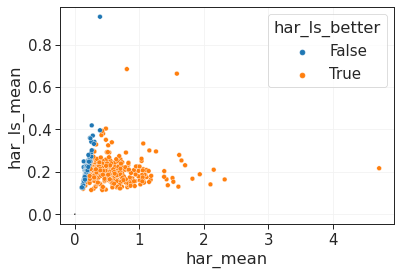

In [231]:
results_df['har_ls_better'] = results_df['har_mean'] > results_df['har_ls_mean']
sns.scatterplot(x="har_mean", y="har_ls_mean", hue = 'har_ls_better', data=results_df.query('har_mean < 40'))
# plt.plot([-10,-7.5],[-10,-7.5], color = 'k')
plt.plot([1e-7,2e-3],[1e-7,2e-3], color = 'k')

NameError: name 'har_trim_level' is not defined

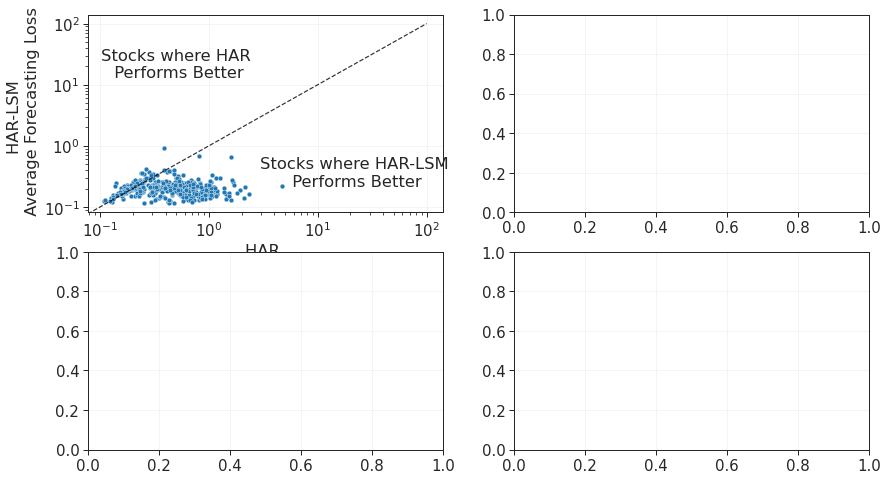

In [232]:
fig, axs = plt.subplots(figsize=(14, 8), nrows = 2, ncols = 2)

## Scatter by stock
ax = axs[0,0]
sns.scatterplot(x="har_mean", y="har_ls_mean", data=results_df, ax = ax)
ax.plot([0, 1e2], [0, 1e2], color="k", ls="dashed", alpha = 0.8)
ax.set_yscale("log")
ax.set_xscale("log")
ax.text(
    0.25,
    0.75,
    f"Stocks where HAR\n Performs Better",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.text(
    0.75,
    0.2,
    f"Stocks where HAR-LSM\n Performs Better",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.set_xlabel('HAR \n Average Forecasting Loss')
ax.set_ylabel('HAR-LSM \n Average Forecasting Loss')


## Scatter by period
ax = axs[0,1]
sns.scatterplot(x = np.mean(results_df.query(f"har_mean < {har_trim_level}")["har_ls_fer"]),
            y = np.mean(results_df.query(f"har_mean < {har_trim_level}")["har_fer"]),
                ax = ax
         )
ax.plot([0,4e1],[0,4e1],color = 'k', ls = '--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xscale("log")
ax.text(
    0.25,
    0.75,
    f"Days where HAR\n Performs Better",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.text(
    0.75,
    0.2,
    f"Days where HAR-LSM\n Performs Better",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.set_xlabel('HAR \n Average Forecasting Loss')
ax.set_ylabel('HAR-LSM \n Average Forecasting Loss')


## Mean Error Diff
har_trim_level = results_df['har_mean'].quantile(0.95)
fer_difference = np.mean(
    np.vstack(results_df.query(f"har_mean < {har_trim_level}")["har_fer"].values),
    axis=0,
) - np.mean(
    np.vstack(results_df.query(f"har_mean < {har_trim_level}")["har_ls_fer"].values),
    axis=0,
)
ax = plt.subplot(2,1,2)
ax.axhline(0, color = 'k', ls = '--')
ax.plot(
    data_rv_df["date"].unique()[(window + skip_rows - 1) :],
    fer_difference,
)
# ax.set_ylim(-2e0, 2e0)
ax.set_ylim(-1e-6, 1e-6)
ax.set_ylabel("$(Avg \;\;HAR\;\; MSE$ \n $-\; Avg \;\;HARLSM\;\; MSE)$")
# ax.set_ylabel('(Mean HAR QLIKE\n -- Mean HAR-LSM QLIKE)', fontsize = 14)
ax.set_xlabel("Date")
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2020-11-01'))


plt.tight_layout()
# plt.savefig('../exhibits/final_paper/harlsm_perf_mse.pdf')

In [233]:
len(results_df['ticker'].unique())

454

In [234]:
np.mean(results_df['har_mean'] > results_df['har_ls_mean'])

0.6938325991189427

In [235]:
np.mean(np.mean(results_df.query(f"har_mean < {har_trim_level}")["har_ls_fer"]) < np.mean(results_df.query(f"har_mean > {har_trim_level}")["har_fer"]))

NameError: name 'har_trim_level' is not defined

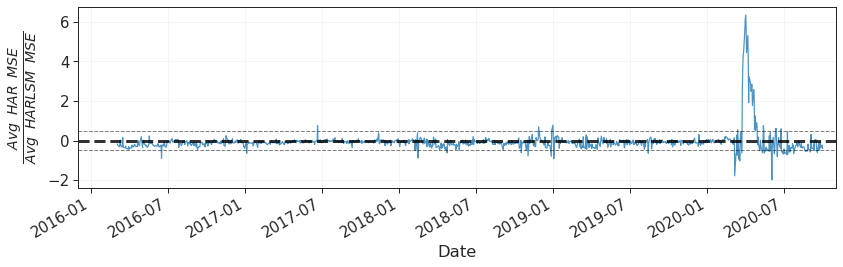

In [237]:
fig, ax = plt.subplots(figsize=(12, 4), nrows = 1)



# ## Median Error Diff
# fer_difference = (np.median(np.vstack(results_df["har_fer"].values), axis = 0) - 
#                   np.median(np.vstack(results_df["har_ls_fer"].values), axis = 0)) 
# ax = axs[1]
# ax.plot(
#     data_rv_df["date"].unique()[(window + skip_rows - 1) :],
#     fer_difference,
# )
# ax.set_ylim(-1e-6, 1e-6)
# # ax.set_ylabel("$(Avg \;\;HAR\;\; MSE$ \n $-\; Avg \;\;HARLSM\;\; MSE)$")
# ax.set_ylabel('(Median HAR MSE\n -- Median HAR-LSM MSE)', fontsize = 14)
# ax.set_xlabel("Date")
# ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2020-11-01'))



## Second axis, relative error
har_trim_level = 1
ax.plot(
    data_rv_df["date"].unique()[(window + skip_rows - 1) :],
    np.log(np.mean(results_df.query(f"har_mean < {har_trim_level}")["har_fer"])) - 
    np.log(np.mean(results_df.query(f"har_mean < {har_trim_level}")["har_ls_fer"])),
    alpha = 0.8
)
ax.axhline(1.5  -1, color = 'k', ls = '--', lw = 1, alpha = 0.5)
ax.axhline(1    -1, color = 'k', ls = '--', lw = 3, alpha = 0.8)
ax.axhline(0.5  -1, color = 'k', ls = '--', lw = 1, alpha = 0.5)
# ax.set_yscale('log')
# ax.set_ylim(0.1, 3)
ax.set_ylabel("$\\frac{Avg \;\;HAR\;\; MSE}{Avg \;\;HARLSM\;\; MSE}$", fontsize = 20)
ax.set_xlabel("Date")
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2020-11-01'))
fig.autofmt_xdate()



plt.tight_layout()
# plt.savefig('../exhibits/final_paper/harlsm_perf_mse_time.pdf')

In [238]:
# results_df[[x + '_fer' for x in reg_names]] = results_df['forecast_error_results'].apply(pd.Series).applymap(np.array)

for reg_name in tqdm(reg_names):
    for reg_name2 in reg_names:
        results_df[reg_name2 + '_vs_' + reg_name + '_Y'] = results_df[reg_name2 + '_fer'] - results_df[reg_name + '_fer']
       

In [239]:
len(results_df['har_fer'].iloc[0])

1154

In [240]:
ticker_list = results_df['ticker'].unique()

def db_reg(ticker, reg_name):

        Y = results_df.query('ticker == @ticker')['har_vs_' + reg_name + '_Y'].iloc[0]
        m = len(Y)
        hac_lags = int(0.75*(m**(1/3)))
        fit = sm.OLS(Y, np.c_[np.ones(m)]
                    ).fit(
            cov_type = 'HAC', cov_kwds = {'maxlags': hac_lags})

        return fit

def temp_f(reg_name):

    if reg_name == 'har':
        return reg_name, None
        
    results = [] 
    
    try:
        for ticker in ticker_list:
            fit = db_reg(ticker, reg_name)
            results.append([fit.tvalues[0], fit.params[0]])
    except:
        return reg_name, None
    
    return reg_name, results

db_results = []

for reg_name, results in tqdm(map(temp_f, reg_names), total = len(reg_names)):
    if results:
        print(reg_name)
        print(f'HAR Better (sig): {np.mean(np.array(results)[:,0] < -1.96):.4%}')
        print(f'HAR Worse (sig):  {np.mean(np.array(results)[:,0] > 1.96):.4%}')
        print(f'HAR Worse (avg):  {np.mean(np.array(results)[:,0] > 0):.4%}')
        print()
        db_results.append(results)

har_ls
HAR Better (sig): 17.1806%
HAR Worse (sig):  0.2203%
HAR Worse (avg):  69.3833%




#### Funnel

In [241]:
db_df = pd.DataFrame(db_results[2], index = ticker_list, columns = ['t', 'coeff'])
db_df['se'] = db_df['coeff']/db_df['t']
db_df

IndexError: list index out of range

In [425]:
har_better_stocks = db_df.query('t < -1.96').index

In [429]:
results_df.query('ticker in @har_better_stocks')['har_ls_mean'].mean()

0.21923845290110974

In [432]:
(
    results_df.query("ticker in @har_better_stocks")["har_ls_mean"].mean()
    / results_df.query("ticker in @har_better_stocks")["har_mean"].mean()
)

1.180918164892428

In [434]:
(
    results_df["har_ls_mean"].mean()
    / results_df["har_mean"].mean()
)

0.5133557374877212

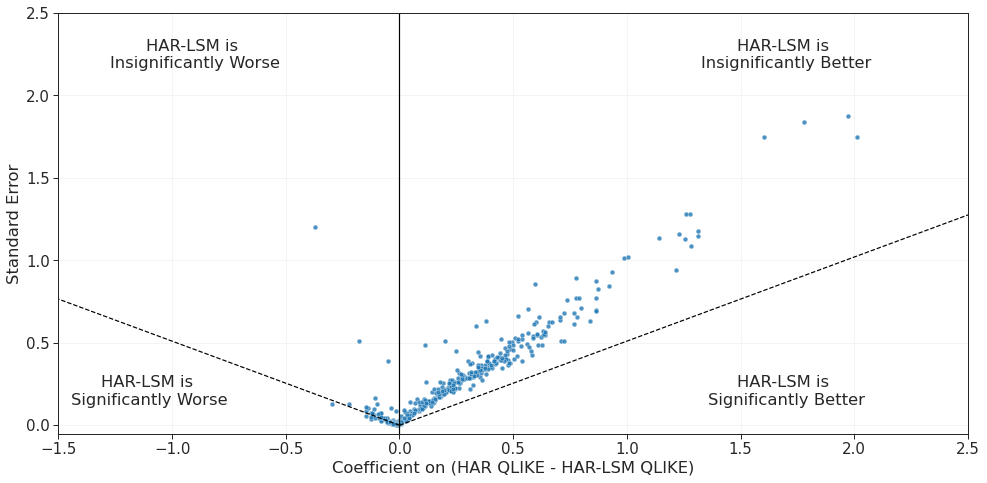

In [408]:
fig, ax = plt.subplots(figsize = (14,7))

sns.scatterplot(x = 'coeff', y = 'se', alpha = 0.8, data = db_df)
ax.text(
    0.1,
    0.1,
    f"HAR-LSM is \nSignificantly Worse",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.text(
    0.8,
    0.1,
    f"HAR-LSM is \nSignificantly Better",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.text(
    0.15,
    0.9,
    f"HAR-LSM is \nInsignificantly Worse",
    ha="center",
    va="center",
    transform=ax.transAxes,
)
ax.text(
    0.8,
    0.9,
    f"HAR-LSM is \nInsignificantly Better",
    ha="center",
    va="center",
    transform=ax.transAxes,
)

sll = 10
ax.plot([0, -sll], [0, sll/1.96], color = 'k', ls = '--')
ax.plot([0, sll], [0, sll/1.96], color = 'k', ls = '--')
ax.axvline(0,1,0, color = 'k', )
ax.set_ylim(-0.05, 2.5)
ax.set_xlim(-1.5, 2.5)
ax.set_xlabel('Coefficient on (HAR QLIKE - HAR-LSM QLIKE)')
ax.set_ylabel('Standard Error')

plt.tight_layout()
# plt.savefig('../exhibits/final_paper/har_vs_harlsm_significance.pdf')